In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw5/data
!rm hw3_data.zip
!pip install ./dul_2021

In [2]:
from dul_2021.utils.hw5_utils import *

In [3]:
import torch
import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn import Conv2d, ConvTranspose2d
from tqdm import trange
from collections import defaultdict

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Question 1: VAEs on Images
In this question, you will train VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

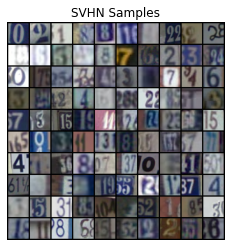

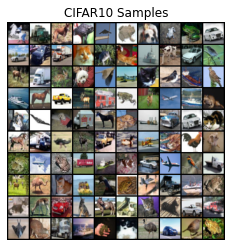

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
# train_svhn_data, test_svhn_data = load_pickled_data(join(get_data_dir(5), 'svhn.pkl'))
# train_cifar_data, test_cifar_data = load_pickled_data(join(get_data_dir(5), 'cifar10.pkl'))

In [ ]:
# train_svhn_data.shape
# train_cifar_data.shape

In [4]:
class Dataset:
    def __init__(self, data):
        self.data = self.__transpose(data)

    @staticmethod
    def __transpose(data):
        return  torch.FloatTensor(data / 255.0).permute(0, 3, 1, 2)
    
    def get_data_loader(self, batch_size: int = 128):
        return DataLoader(self.data, 
                          pin_memory = True, 
                          shuffle=True,
                          batch_size=batch_size)

In [ ]:
# d = Dataset(train_svhn_data)
# dataloader = d.get_data_loader()
# next(iter(dataloader)).shape

In [12]:
config = {"encoder":
          {"n_encoder_layers": 3,
           "out_channels": 32,
           "flatten_dim": 16,
           "lattent_dim": 128},
         "decoder":
          {"n_decoder_layers": 3,
           "in_channels": 128,
           "in_img_size": 4,
           "lattent_dim": 128},
          "vae":
          {"grad_clip": 1,
           "epochs": 15,
           "lr": 1e-3,
           "verbose": 5, 
           "lattent_dim": 128, 
           "n_samples": 100}
          }

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        for key, value in kwargs.items():
            setattr(self, key, value)

        relu = torch.nn.ReLU()
        model = [Conv2d(3, self.out_channels, 3, 1, 1)]
        in_channels = self.out_channels

        for _ in range(self.n_encoder_layers):
            out_channels = in_channels * 2
            model.extend([relu, Conv2d(in_channels, out_channels, 3, 2, 1)])
            in_channels = out_channels

        self.model = torch.nn.Sequential(*model)
        self.linear = torch.nn.Linear(self.flatten_dim * 256, self.lattent_dim * 2)

    def forward(self, x):
        output = self.model(x)  # batch_size, sqrt(self.flatten_dim), sqrt(self.flatten_dim)
        output = output.reshape(output.shape[0], -1)
        output = self.linear(output)
        mu, log_std = output.chunk(2, dim=1)
        return mu, log_std  

In [7]:
encoder = Encoder(**config["encoder"])
encoder.model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

In [8]:
class Decoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        for key, value in kwargs.items():
            setattr(self, key, value)

        self.linear = torch.nn.Linear(
            self.lattent_dim, self.in_channels * self.in_img_size * self.in_img_size
            )
        
        relu = torch.nn.ReLU()
        out_channels = self.in_channels
        in_channels = self.in_channels
        model = []
        for _ in range(self.n_decoder_layers):
          model.extend([ConvTranspose2d(in_channels, out_channels, 4, 2, 1), relu])
          in_channels = out_channels
          out_channels = out_channels // 2

        self.model = torch.nn.Sequential(*model)
        self.conv_layer = Conv2d(in_channels, 3, 3, 1, 1)

    def forward(self, x):
        output = F.relu(self.linear(x))
        output = output.reshape(
            output.shape[0],self.lattent_dim, self.in_img_size, self.in_img_size)
        output = self.model(output)
        output = self.conv_layer(output)
        return output

In [9]:
decoder = Decoder(**config["decoder"])
decoder.model

Sequential(
  (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)

In [20]:
class VAE(torch.nn.Module):
    def __init__(self, config):
      super().__init__()
      for key, value in config["vae"].items():
        setattr(self, key, value)
      self.encoder = Encoder(**config["encoder"])
      self.decoder = Decoder(**config["decoder"])
      self.encoder.to(device)
      self.decoder.to(device)
      self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)


    def loss(self, x):
      x = 2 * x - 1
      mu, std = self.encoder(x)
      z = torch.randn_like(mu) * std.exp() + mu
      x_hat = self.decoder(z)

      rc_loss = F.mse_loss(x, x_hat, reduction='none').view(x.shape[0], -1).sum(1).mean()
      kl_loss = -std - 0.5 + (torch.exp(2 * std) + mu ** 2) * 0.5
      kl_loss = kl_loss.sum(1).mean()
      el_loss = rc_loss + kl_loss

      return defaultdict(el_loss=el_loss, rc_loss=rc_loss, kl_loss=kl_loss) 


    def sample(self, n):
      with torch.no_grad():
          z = torch.randn(n, self.lattent_dim).to(device)
          samples = torch.clamp(self.decoder(z), -1, 1)
          samples = samples.detach().cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5
      return samples * 255.


    def reconstruct(self, x):
      x = x.to(device)
      with torch.no_grad():
        x = 2 * x - 1
        mu = self.encoder(x)[0]
        x_hat = torch.clamp(self.decoder(mu), -1, 1)
        reconstructions = torch.stack((x, x_hat), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
        reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy()
      return reconstructions * 255.


    def interpolate(self, x):
      x = x.to(device)
      with torch.no_grad():
        x = 2 * x - 1
        z = self.encoder(x)[0]
        z1, z2 = z.chunk(2, dim=0)
        dist = np.linspace(0, 1, 10)
        interpolations = [self.decoder(z1 * (1 - i) + z2 * i) for i in dist]
        interpolations = torch.stack(interpolations, dim=1).view(-1, 3, 32, 32)
        interpolations = torch.clamp(interpolations, -1, 1) * 0.5 + 0.5
        interpolations = interpolations.permute(0, 2, 3, 1).cpu().numpy()
      return interpolations * 255.


    def train_loop(self, train_loader, val_loader):
      self.train()
      train_losses, test_losses = defaultdict(lambda: []), defaultdict(lambda: [])
      for epoch in trange(self.epochs):
        epoch_train_losses = defaultdict(lambda: [])
        for x in train_loader:
          x = x.to(device)
          torch.cuda.empty_cache()
          
          losses = self.loss(x)
          self.optimizer.zero_grad()
          losses['el_loss'].backward()
          torch.nn.utils.clip_grad_norm_(self.parameters(), self.grad_clip)
          self.optimizer.step()

          for k in losses.keys():
            epoch_train_losses[k].append(losses[k].item())
          

        for k in epoch_train_losses.keys():
          train_losses[k].append(np.mean(epoch_train_losses[k]))

        if epoch % self.verbose == 0:
          epoch_eval_losses = self.evaluation(val_loader)
          for k in epoch_eval_losses.keys():
            test_losses[k].append(np.mean(epoch_eval_losses[k]))

      train_losses = np.stack(
          (train_losses['el_loss'], 
           train_losses['rc_loss'], 
           train_losses['kl_loss']), axis=1)
      
      test_losses = np.stack(
          (test_losses['el_loss'], 
           test_losses['rc_loss'], 
           test_losses['kl_loss']), axis=1)
      
      samples = self.sample(self.n_samples)
      
      return train_losses, test_losses, samples


    def evaluation(self, val_loader):
      self.eval()
      epoch_val_losses = defaultdict(lambda: [])
      with torch.torch.no_grad():
        for x in val_loader:
          x = x.to(device)
          losses = self.loss(x)
          for k in losses.keys():
            epoch_val_losses[k].append(losses[k].item())
      return epoch_val_losses


In [16]:
def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    train_dataset = Dataset(train_data)
    test_dataset = Dataset(test_data)

    train_dataloader = train_dataset.get_data_loader()
    test_dataloader = test_dataset.get_data_loader()

    vae = VAE(config)

    train_losses, test_losses, samples = vae.train_loop(train_dataloader, test_dataloader)

    reconstructions = vae.reconstruct(next(iter(test_dataloader))[:50])
    interpolations = vae.interpolate(next(iter(test_dataloader))[:20])

    return train_losses, test_losses, samples, reconstructions, interpolations


### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

100%|██████████| 15/15 [02:19<00:00,  9.33s/it]


Final -ELBO: 112.3376, Recon Loss: 79.7468, KL Loss: 32.5908


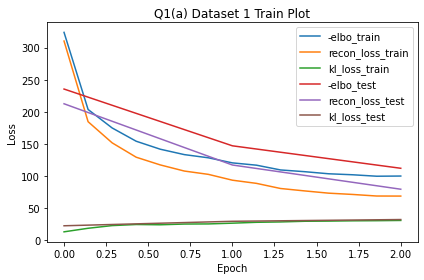

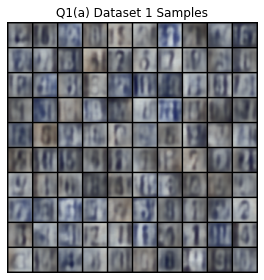

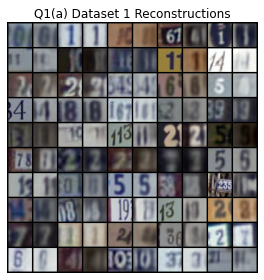

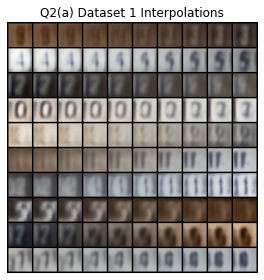

In [21]:
q1_save_results('a', 1, q1_a)

100%|██████████| 15/15 [11:29<00:00, 45.97s/it]


Final -ELBO: 188.1084, Recon Loss: 125.4788, KL Loss: 62.6296


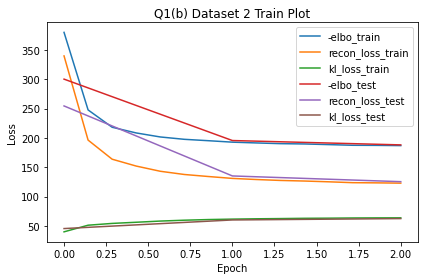

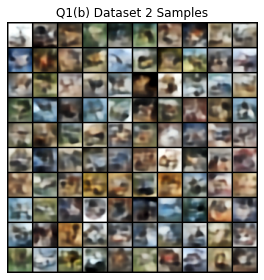

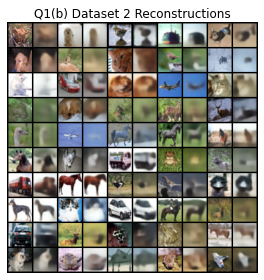

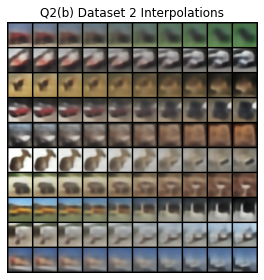

In [22]:
q1_save_results('b', 2, q1_a)